## Adding Batch Normalization to MLP

The following code is simply cleaner starter code from the MLP notebook. In this notebook, we will be diving deeper into improvements on the MLP so that we can gradually ramp up into RNN's and GRU's.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [2]:
# read in all the words
data = open('names.txt', 'r').read().splitlines()
data[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(data))))
stringtoint = {s:i+1 for i,s in enumerate(chars)}
stringtoint['.'] = 0
inttostring = {i:s for s,i in stringtoint.items()}
vocab_size = len(inttostring)
print(inttostring)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stringtoint[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(data)
n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr,  Ytr  = build_dataset(data[:n1])     # 80%
Xdev, Ydev = build_dataset(data[n1:n2])   # 10%
Xte,  Yte  = build_dataset(data[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


One problem that we notice in our model is that the initial loss is way too high (around 30). Why is this a problem? Well ideally, we'd expect the weight initialization to not give very extreme values for the logits (counts) which would cause the first iteration to have extremely high loss. Normally, we would expect a neural network that hasn't been trained to uniformly pick from the possible logits (as it has no info on which character is more likely so it samples via uniform distribution). We do this by altering initializations accordingly. 

To ensure that the initializations of our weight matrices (W1, W2) are unit Gaussian rather than having a scaled down standard dev, we should multiply by gain/sqrt(fan_in), which is based of the Kaiming et al. paper. For W1, we would multiply the weight matrix by 5/3 (which is the gain) divided by sqrt(fan_in) where fan_in is 30 (because our embedding is 10 dimensions and we have 3 of them as shown in the paper). 

In [15]:
#MLP Model

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((27, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * 5/3 * 1/((n_embd * block_size)**0.5) #kaiming initialization
#b1 = torch.randn(n_hidden) * 0.01 Why not needed?: In batch normalization the biases for linear layers prior to activation actually don't have any impact because we end up subtracting it out when normalizing. This saves compute. Bias is introduced when we do batch normalization anyway (bnbias) so no need to be wasteful.
W2 = torch.randn((n_hidden, 27)) * 0.01 #scales down W2 so that logits aren't extremely crazy values. Think about why this isn't zero.
b2 = torch.randn(27) * 0 #removes unnecessary bias at initialization

bngain = torch.ones((1, n_hidden)) # we need this so our model isn't "forcing" our predictions ot be unit gaussian. This is only a trait we desire at initialization and we want backprop to tell us the impact of each neuron rather than making it gaussian. They are trained/learned via backprop. 
bnbias = torch.zeros((1, n_hidden))
running_bnmean = torch.zeros((1, n_hidden))
running_bnstd = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


NOW, for Batch Normalization. Remember the part where we initialized our weights via Kaiming initialization? What if we just directly normalized our pre-activation hidden layer? Turns out we can, as its differentiable and will end up giving us the unit gaussian we desire.

In [16]:
steps = 30000
batch_size = 32
loss_i = []

for i in range(steps):
    
    #minibatch construction: The idea behind minibatches is that its much better to compute the approximate gradient and make many more steps than to compute the exact gradient and take fewer steps.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    
    #forward pass
    embed = C[Xtr[ix]]
    
    #Linear layer
    h_pre_activation = embed.view(embed.shape[0], (embed.shape[1] * embed.shape[2])) @ W1 #+ b1
    
    #Batch normalization layer
    bnmean_i = h_pre_activation.mean(0, keepdim=True)
    bnstd_i = h_pre_activation.std(0, keepdim=True)
    h_pre_activation = bngain * (h_pre_activation - bnmean_i) / bnstd_i + bnbias #Batch normalization. We are normalizing each batch of size 32. See initialization block for note on bngain and bnbias. 
    with torch.no_grad(): 
        running_bnmean = 0.999 * running_bnmean + 0.001 * bnmean_i
        running_bnstd = 0.999 * running_bnstd + 0.001 * bnstd_i
        
    h = torch.tanh(h_pre_activation)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 #note: once we see that the current lr isn't making a dent in the loss, we can decay it to a smaller value. Think about why this makes sense intuitively. (it's because when we're deep in the valley we want to make smaller steps to converge on the minimum)
    for p in parameters:
        p.data += -lr * p.grad
    
    #stats
    loss_i.append(loss.log10().item())
print(loss.item())

1.7707327604293823


Another optimization we can perform centers around our tanh squishification function. Recall that tanh smoothly squishes values between -1 and 1. But if we look at the output from our activation layer, we see that the values concentrate at the extrema (-1, and 1). Why is this bad? During backpropagation, we will actually be "stopping the gradient." When we apply chain rule during backprop, the first derivative of tanh gets sent to 0 if the input is 1 or -1. We are in a flat region of the tanh function (near 1 or -1), where changing the input will not meaningfully impact the loss. This can cause what is known as a dead neuron. We can fix this by scaling down W1 and doing the same with b1. This will allow the preactivation layer (before tanh is applied) to not have crazy extreme values. 

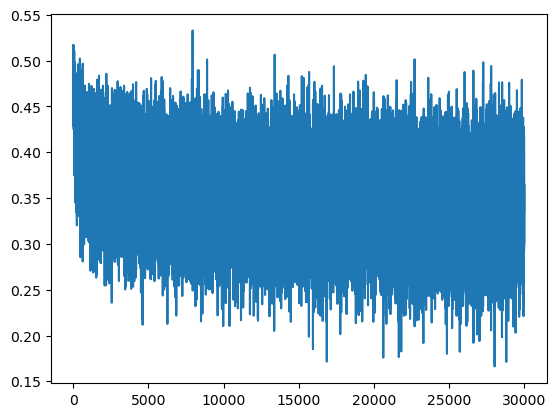

In [7]:
plt.plot(loss_i)

Notice how our loss from above doesn't look like a hockey stick anymore with an extremely high drop off in loss after the first few iterations. This is good because in the beginning, the neural network is doing the easy part, and just learning to scale down the logits, which isn't real learning. The real learning occurs after this happens so we manually cut out that part by scaling down W2. Now we see a lot more noisy loss, but we can optimize on this to improve our model's performance.

Sampling from model

In [14]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(inttostring[i] for i in out))

jaideon.
naya.
saaya.
ella.
jael.
kar.
velek.
amyla.
kari.
bow.
lor.
mel.
phnissa.
kate.
nawy.
cholty.
vani.
kael.
kyna.
nayda.


After we did a simple fix on the softmax (scaling down W2 and b2), this allowed for more productive learning because the first few iterations were not spent trying to just scale down W2 and b2 to minimize loss, but rather spent on meaningful learning. We improved this further by fixing the over-saturation of tanh at the extrema (by scaling down W1 and b1), which prevented dead neurons and allowed for more "learning" to occur because gradients were able to be properly expressed in backprop. The output above just shows howo much better the names are after making these tiny changes. After adding batch normalization, which is a cohesive way to control the "statistics" of our activations (ie making them unit gaussian to avoid the problems such as dead neurons and inefficient training), training loss drops. However, it is often not used in production due to the numerous amount of bugs that it brings due to the fact that its coupling batches when calculating the mean and std. Alternatives include layer normalization or group normalization. 

Below, we will fully modularize/PyTorchify the code so it resembles PyTorch code in a more production-like setting.